In [1]:
import joblib
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Test trained model on new dataset (on metadata)

In [2]:
# Load the trained model from joblib file

# # Parameters from Optuna 
# n_estimators = 80
# max_depth = 12
# learning_rate = 0.1684744342969461
# gamma = 0.2935882001439162
# min_child_weight = 4
# 
# model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, min_child_weight=min_child_weight, random_state=42)

model = joblib.load('models/xgb_metadata_v1_8_genres_smote_normalized.joblib')

# Load the new dataset
df = pd.read_csv('data/fma_cut100_echonest_lyrics_fake_country.csv', header=[0, 1])

In [3]:
df.sample(3)

track    album                                                         \
    track_id comments         date_created        date_released     engineer   
357    63775        0  2012-04-18 12:40:00  2012-04-14 00:00:00     Mike Sin   
401     3515        0  2008-12-04 09:26:38  2006-06-27 00:00:00  Gil Shuster   
558    49843        1  2011-06-29 16:34:02  2011-03-08 00:00:00          NaN   

                                                                         \
    favorites     id                                        information   
357         0  11516  <p><strong>CHAIN AND THE GANG Live on The Cher...   
401         1    734  <p><span>London's masters of satirical, fallin...   
558        23   9464  <p>three girls from Denmark, Sweden and Icelan...   

                      ...     track                                     \
    listens producer  ... one_genre danceability    energy speechiness   
357    3597  Terre T  ...      Rock     0.624407  0.815669    0.111800   
401    5854      NaN  ...      Rock     0.660324  0.698184    0.038514   
558   29632      NaN  ...   Country     0.556328  0.024630    0.048705   

                                                                             
    acousticness instrumentalness  liveness   valence    tempo track_folder  
357     0.365769     8.200000e-09  0.051645  0.749134  138.770           63  
401     0.825608     9.659841e-01  0.109871  0.723314  155.020            3  
558     0.990580     1.146700e-05  0.103911  0.258253   65.207           49  

[3 rows x 67 columns]

In [4]:
df[('album','year_released')] = df[('album', 'date_released')].str.extract(r'(\d{4})')

In [5]:
# Select the features from the new dataset
features = [('track', 'danceability'), ('track', 'energy'), ('track', 'speechiness'), ('track', 'acousticness'), ('track', 'instrumentalness'), ('track', 'liveness'), ('track', 'valence'), ('track', 'tempo'), ('track', 'duration'), ('album', 'year_released')]

In [6]:
from sklearn.preprocessing import StandardScaler

X = df[features]
y = df[('track', 'one_genre')]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [7]:
label_encoder.classes_

array(['Country', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'Rap',
       'Rock'], dtype=object)

In [8]:
# Sample X
X[:5]

array([[ 0.18405976,  0.09947015, -0.22083213, -0.48698639,  1.13125619,
        -0.62385964,  0.27723869,  1.06311612,  0.78389997, -1.10138778],
       [-0.79285179,  1.04386124,  4.17166566, -0.07822536, -1.21567887,
         1.29677798,  1.02189904, -1.05311257, -0.12855917,         nan],
       [-0.25647753,  0.47128059,  3.03627977,  1.19461857, -1.17139083,
        -0.58096541,  1.17021582,  1.28418754, -0.88179726,         nan],
       [ 1.298953  ,  0.73828367, -0.10132005,  0.23631117,  0.63109602,
        -0.51051839, -0.05310436, -0.89981813, -0.99815111,         nan],
       [ 0.35203927,  0.23227779,  2.98446874,  0.56537367, -1.19789528,
        -0.50433726, -1.0767329 , -1.01413941, -0.98590333,         nan]])

In [9]:
# Sample y
y[:5]

array([1, 1, 1, 1, 1])

In [10]:
y_pred = model.predict(X)
# Get probabilities for each class for each sample
y_pred_proba = model.predict_proba(X)
print(classification_report(y, y_pred, target_names=list(label_encoder.inverse_transform([0,1,2,3,4,5,6,7]))))
accuracy_score(y, y_pred)

              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        60
     Hip-Hop       0.34      0.35      0.34        43
       Indie       0.15      0.11      0.12        95
        Jazz       0.39      0.32      0.35        82
       Metal       0.36      0.31      0.33        51
         Pop       0.40      0.27      0.32       100
         Rap       0.30      0.65      0.41        46
        Rock       0.27      0.40      0.32       100

    accuracy                           0.28       577
   macro avg       0.28      0.30      0.28       577
weighted avg       0.28      0.28      0.27       577



0.28422876949740034

In [11]:
# Get probabilities, and the predicted class for 1st sample
print(y_pred_proba[0])
print(y_pred[0])
print(y[0])

# Get as genres not as numbers
print(label_encoder.inverse_transform([y[0]]))
print(label_encoder.inverse_transform([y_pred[0]]))

[0.0049148  0.00407911 0.00359954 0.06472711 0.00380014 0.10632218
 0.45183045 0.3607267 ]
6
1
['Hip-Hop']
['Rap']


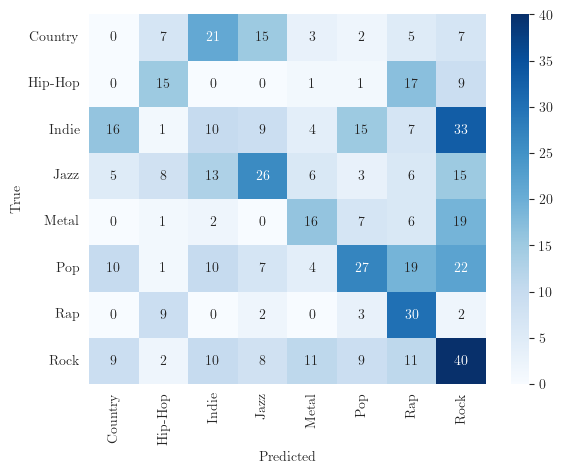

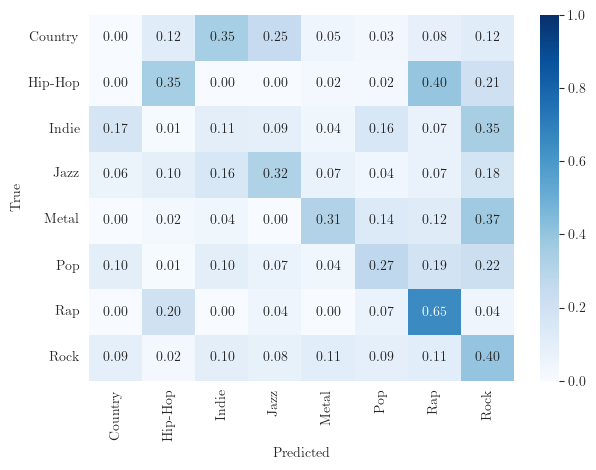

In [12]:
# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Plot confusion matrix with genre names
genre_names = list(label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, xticklabels=genre_names, yticklabels=genre_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Normalize confusion matrix with genre names
cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, xticklabels=genre_names, yticklabels=genre_names, fmt='.2f', cmap='Blues', vmax=1.0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix_metadata_xgb_8_genres_smote.png', dpi=300)
plt.show()
